In [2]:
import sys
sys.path

['..',
 'c:\\Users\\LENOVO\\Documents\\Github\\CS336.O11.KHCL\\test',
 'C:\\Users\\LENOVO\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip',
 'C:\\Users\\LENOVO\\AppData\\Local\\Programs\\Python\\Python310\\DLLs',
 'C:\\Users\\LENOVO\\AppData\\Local\\Programs\\Python\\Python310\\lib',
 'C:\\Users\\LENOVO\\AppData\\Local\\Programs\\Python\\Python310',
 'c:\\Users\\LENOVO\\Documents\\Github\\CS336.O11.KHCL\\.venv',
 '',
 'c:\\Users\\LENOVO\\Documents\\Github\\CS336.O11.KHCL\\.venv\\lib\\site-packages',
 'c:\\Users\\LENOVO\\Documents\\Github\\CS336.O11.KHCL\\.venv\\lib\\site-packages\\win32',
 'c:\\Users\\LENOVO\\Documents\\Github\\CS336.O11.KHCL\\.venv\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\LENOVO\\Documents\\Github\\CS336.O11.KHCL\\.venv\\lib\\site-packages\\Pythonwin']

In [2]:
from utils.load_clip import load_clip_model
import numpy as np

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = load_clip_model("../finetuned_RN50.pt")

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
from utils.indexer import VectorIndexer
from pathlib import Path

features_file =  Path("../data") / "features.npy"
images_ids_file = Path("../data") / "images_ids.csv"
index_file = Path("../data") / "dataset.index"

index = VectorIndexer(features_file, images_ids_file)
index.load_index(index_file)

In [4]:
import torch.nn.functional as F
import clip
from PIL import Image

def extract_query_features(query_path, text):
    query = Image.open(query_path)

    query_preprocessed = preprocess(query).unsqueeze(0).to(device)

    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(text).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

        image_features = model.encode_image(query_preprocessed)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    combined_features = F.normalize(image_features + text_features, dim=-1)

    return combined_features.cpu().numpy()

In [5]:
import matplotlib.pyplot as plt

def show_image_list(list_images, list_titles=None, grid=False, num_cols=5, figsize=(20, 10), title_fontsize=24):
    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        
        list_axes[i].imshow(img)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

In [22]:
# Load the query image
val_dataset_path = Path("../splited_fashionIQ") / "val"
query_path = val_dataset_path / "B000AYI3L4.png"
text = "a pink dress with star in the middle"

query_features = extract_query_features(query_path, text)

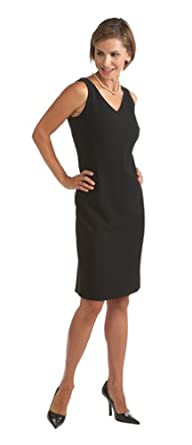

In [19]:
Image.open(query_path)

In [23]:
result = index.search(query_features, k=50)
print(result)

[{'image': 'B000AYI3L4.png', 'similarity': 0.2843642234802246}, {'image': 'B00BGIFKM8.png', 'similarity': 0.3205292224884033}, {'image': 'B008S0HK3Y.png', 'similarity': 0.3281059265136719}, {'image': 'B005PP424A.png', 'similarity': 0.328268826007843}, {'image': 'B00CHRYMOO.png', 'similarity': 0.331351637840271}, {'image': 'B00CGY6RKU.png', 'similarity': 0.3335920572280884}, {'image': 'B00APKHEMC.png', 'similarity': 0.33606410026550293}, {'image': 'B00A2ZNBO0.png', 'similarity': 0.3381839990615845}, {'image': 'B00EZITMBQ.png', 'similarity': 0.3406391143798828}, {'image': 'B00BJ1NFNI.png', 'similarity': 0.34183794260025024}, {'image': 'B008ZE09GI.png', 'similarity': 0.34289413690567017}, {'image': 'B002TXI512.png', 'similarity': 0.34421873092651367}, {'image': 'B009W66L92.png', 'similarity': 0.3450956344604492}, {'image': 'B002XUY8SA.png', 'similarity': 0.3468508720397949}, {'image': 'B002EANP9W.png', 'similarity': 0.34703415632247925}, {'image': 'B00CLNO6C2.png', 'similarity': 0.3471781

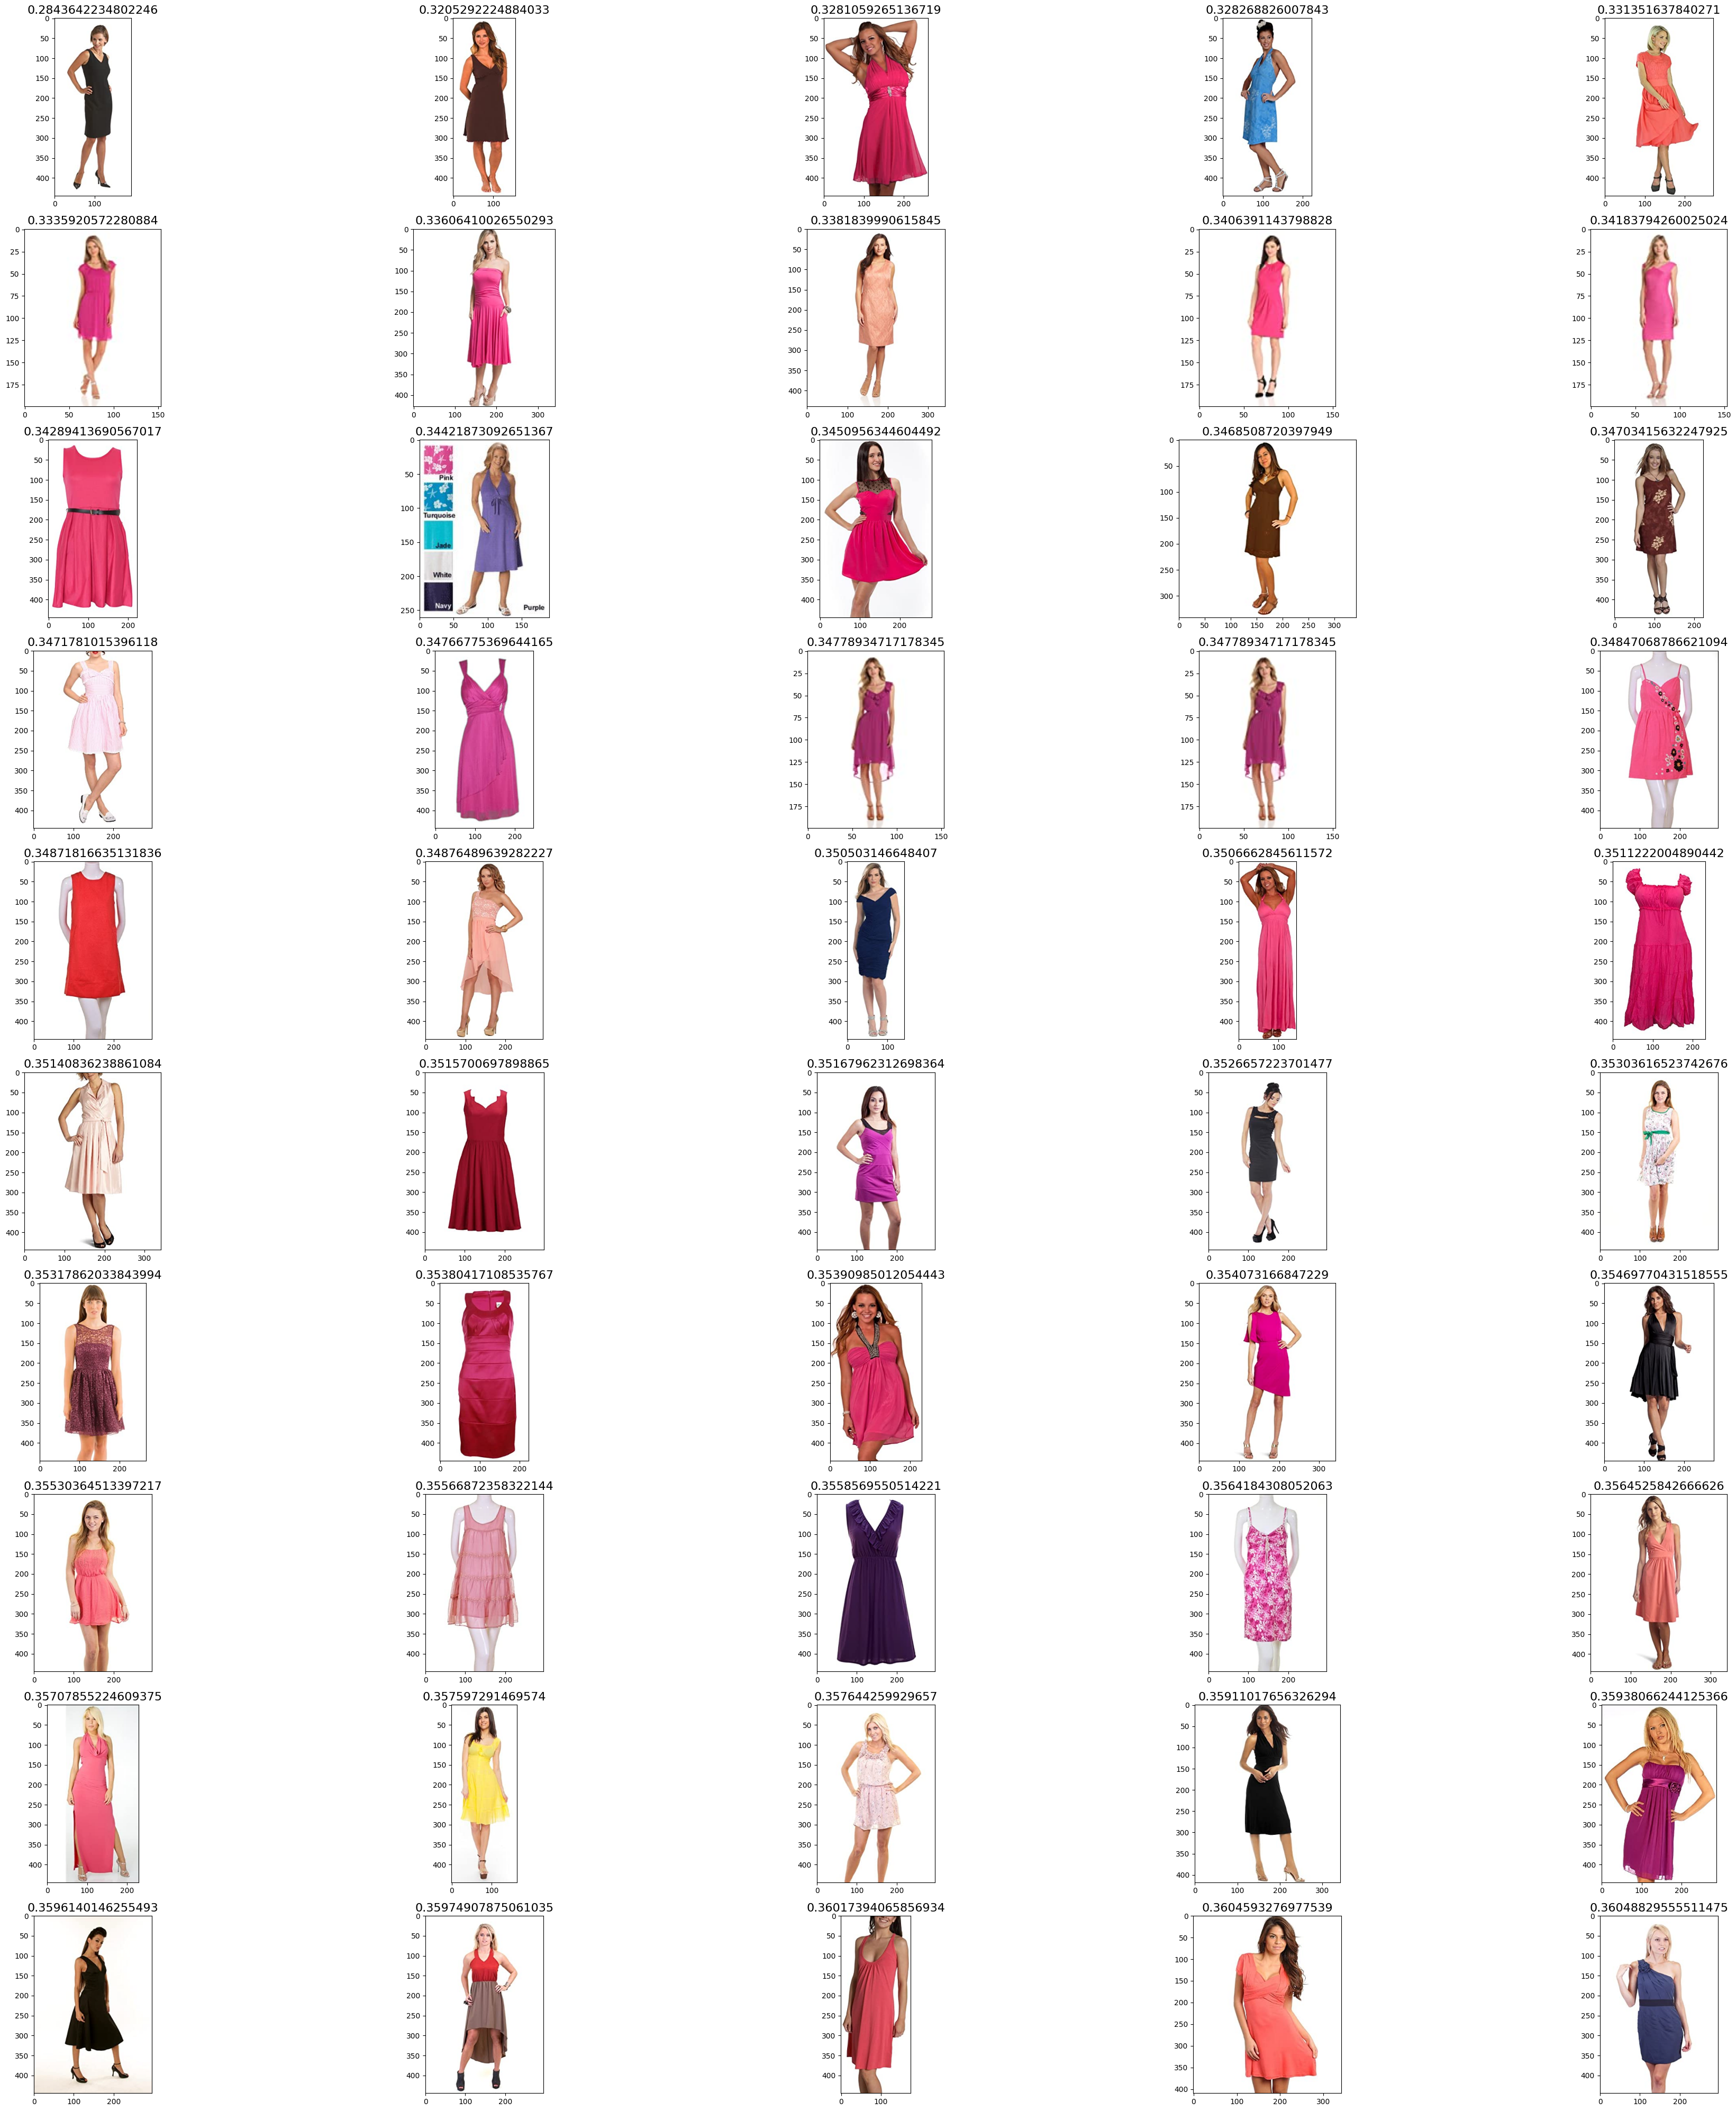

In [24]:
show_image_list(list_images=[Image.open(val_dataset_path / obj['image']) for obj in result],
                list_titles=[obj['similarity'] for obj in result],
                num_cols=5,
                figsize=(40, 40),
                grid=False,
                title_fontsize=16)